# **Milestone 2**

We have built two Convolutional Neural Network architectures in Milestone 1. Here, we will further try to achieve better performance by increasing the number of parameters/weights. Therefore, we will start this Milestone with three popular Transfer Learning architectures, namely, VGG16, ResNet v2, and Efficient Net. Please feel free to explore other pre-trained models as well. Link to Keras documentation for pre-trained models - https://keras.io/api/applications/



## **Mounting the Drive**


In [59]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing the Libraries**

In [60]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### **Let us load the data**

In [61]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [62]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In [63]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)
validation_set = datagen_train.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

test_set = datagen_train.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = 128,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [64]:
# Fixing the seed for random number generators

np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [64]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### **Model Building**

In [76]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable = False



# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Adding a Dense layer with 256 neurons
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(0.4)(x)
# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

### **Compiling and Training the VGG16 Model**

In [77]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [78]:
optimizer = tf.keras.optimizers.Adam(0.0001)
vggmodel.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [79]:
history = vggmodel.fit(train_set, validation_data = validation_set, epochs = 20)



Epoch 1/20
473/473 [==============================] - 25s 51ms/step - loss: 1.4664 - accuracy: 0.2823 - val_loss: 1.2904 - val_accuracy: 0.4193
Epoch 2/20
473/473 [==============================] - 24s 50ms/step - loss: 1.3524 - accuracy: 0.3265 - val_loss: 1.2873 - val_accuracy: 0.4169
Epoch 3/20
473/473 [==============================] - 24s 51ms/step - loss: 1.3212 - accuracy: 0.3476 - val_loss: 1.2737 - val_accuracy: 0.4398
Epoch 4/20
473/473 [==============================] - 24s 51ms/step - loss: 1.2912 - accuracy: 0.3783 - val_loss: 1.2416 - val_accuracy: 0.4298
Epoch 5/20
473/473 [==============================] - 24s 50ms/step - loss: 1.2717 - accuracy: 0.3925 - val_loss: 1.2220 - val_accuracy: 0.4579
Epoch 6/20
473/473 [==============================] - 24s 50ms/step - loss: 1.2534 - accuracy: 0.4141 - val_loss: 1.2388 - val_accuracy: 0.4432
Epoch 7/20
473/473 [==============================] - 24s 50ms/step - loss: 1.2384 - accuracy: 0.4270 - val_loss: 1.1686 - val_accuracy:

### **Evaluating the VGG16 model**

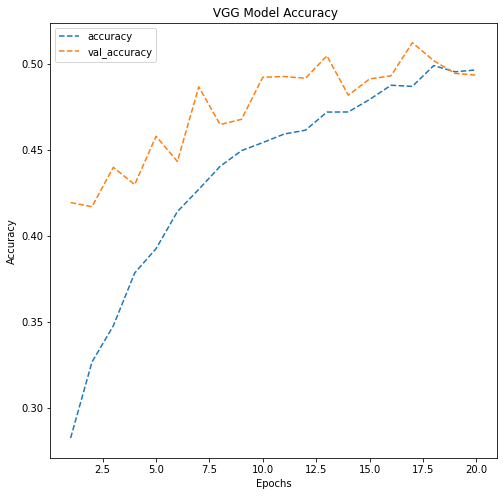

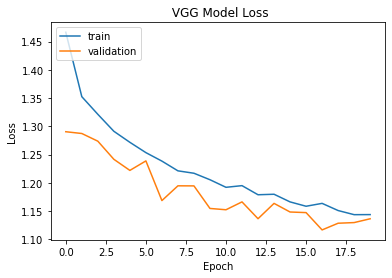

In [80]:
# Write your code to evaluate model performance on the test set

dict_hist = history.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))


plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.title(' VGG Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

#plot loss of model1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' VGG Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


4/4 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.57      0.38      0.45        32
           1       0.38      0.56      0.46        32
           2       0.41      0.41      0.41        32
           3       0.71      0.62      0.67        32

    accuracy                           0.49       128
   macro avg       0.52      0.49      0.50       128
weighted avg       0.52      0.49      0.50       128



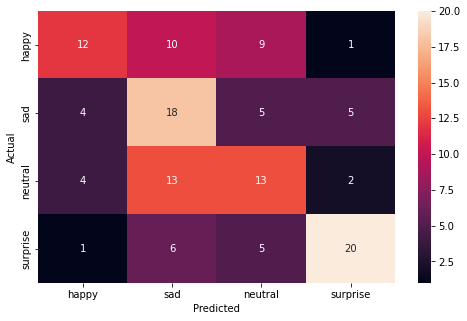

In [81]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = vggmodel.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:
-  The training accuracy fairly smoothly trends up and starts to flatten out around 15 epochs.
- The validation accuracy follows closely but is much noisier and around 20 epochs reaches a little under 50% accuracy. 
- this accuracy is worse than the CNN models without transfer learning, and is not an acceptable accuracy to use.  
- The validation accuracy is slightly above the Training accuracy meaning the model is generalizing well. 
- The model loss is smoothed out by dropping the learning rate.
- The validation loss remains below the the training loss, 
- which again shows the model is generalizing well and not over fitting.
- The confusion matrix shows that the model is confusing happy with both sad and neutral, 1/3 of the time each
- sad is confused 1/6 of the time with each other emotion. 
- Neutral is misclassified as sad as much as it is properly classified
- this is again shows the model is struggling to find a difference in the features on neutral and sad, which are very similar according do data analysis in milestone 1.
- The model does the best on surprised, where it misclasifies 1/3 of the time. 
our recall for happy is very low at 0.38 and precision is not great at 0.57.
- the F1 score is only 0.45 which again is not great
- surprised has the best precision recall and f1 score by a lot.  
- I believe the reason this model performs so poorly is because the vgg16 is not trained on faces, but object recognition. 
- the weights do not translate well into facial emotion recognition.
**

In [61]:
from tensorflow.keras import backend

backend.clear_session()

In [62]:
# Fixing the seed for random number generators

np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

## **ResNet V2 Model**

In [68]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))


### **Model Building**

In [69]:
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=False

# Add classification layers on top of it

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_Resnet.output)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [70]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )  # Write your code here. You may play around with the hyperparameters if you wish.


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001) # Write your code here. You may play around with the hyperparameters if you wish.


callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10



In [71]:
optimizer = tf.keras.optimizers.Adam(0.0001)
resnetmodel.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [72]:
history1 = resnetmodel.fit(train_set, validation_data = validation_set, epochs = 10)


Epoch 1/10
473/473 [==============================] - 33s 57ms/step - loss: 1.5057 - accuracy: 0.2541 - val_loss: 1.3848 - val_accuracy: 0.2443
Epoch 2/10
473/473 [==============================] - 26s 55ms/step - loss: 1.4294 - accuracy: 0.2578 - val_loss: 1.4099 - val_accuracy: 0.2443
Epoch 3/10
473/473 [==============================] - 25s 54ms/step - loss: 1.4023 - accuracy: 0.2567 - val_loss: 1.4102 - val_accuracy: 0.2443
Epoch 4/10
473/473 [==============================] - 25s 54ms/step - loss: 1.3937 - accuracy: 0.2544 - val_loss: 1.3817 - val_accuracy: 0.2289
Epoch 5/10
473/473 [==============================] - 25s 54ms/step - loss: 1.3921 - accuracy: 0.2673 - val_loss: 1.3800 - val_accuracy: 0.2289
Epoch 6/10
473/473 [==============================] - 25s 53ms/step - loss: 1.3896 - accuracy: 0.2659 - val_loss: 1.3820 - val_accuracy: 0.2289
Epoch 7/10
473/473 [==============================] - 25s 53ms/step - loss: 1.3874 - accuracy: 0.2673 - val_loss: 1.3796 - val_accuracy:

### **Evaluating the ResNet Model**

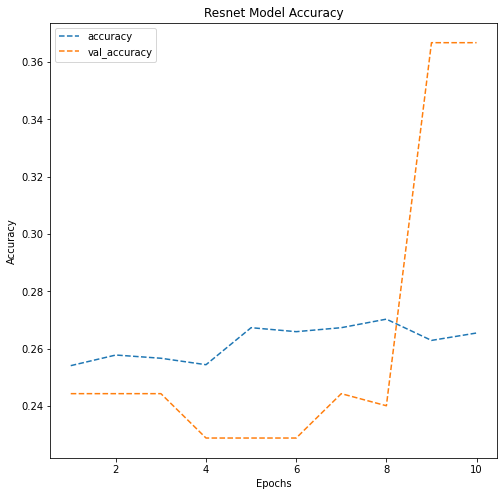

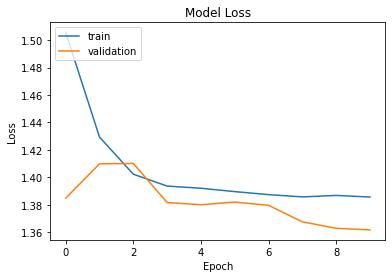

In [73]:
# Write your code to evaluate model performance on the test set
dict_hist = history1.history

list_ep = [i for i in range(1, 11)]

plt.figure(figsize = (8, 8))


plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.title('Resnet Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

#plot loss of model1
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Resnet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4/4 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        32
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        32

    accuracy                           0.25       128
   macro avg       0.06      0.25      0.10       128
weighted avg       0.06      0.25      0.10       128



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


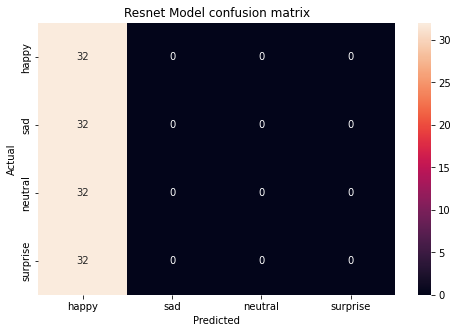

In [74]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = resnetmodel.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Resnet Model confusion matrix')
plt.show()

**Observations and Insights:
- The results from the resnet model are terrible
- although the model is not over fitting, it seems to not be learning at all.
- the Training accuracy remains around 0.25, and the validation accuracy spikes 0.367, but would shortly send back down to about 0.25 no matter the number of epochs ran. 
- After attempting to use different activations, different optimization methods, and different learning rates, I concluded that this model is just not made for facial emotional recognition. 
- The Training loss levels out after about 3 epochs and stays at 1.41 and the validaion accuracy sits at 1.375, both not good results. 
- The confusion matrix gives no insight as it places all of the test data into the happy category.

**


Running the resnet model and retraining the weights 

In [84]:
from tensorflow.keras import backend

backend.clear_session()

In [85]:
# Fixing the seed for random number generators

np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [86]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))


In [87]:
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=True


# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_Resnet.output)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)


x = Dropout(0.3)(x)


x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)


pred = Dense(4, activation = 'softmax')(x)

resnetmodel2 = Model(Resnet.input, pred) # Initializing the model

In [88]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )  


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001) 

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10



In [89]:
optimizer = tf.keras.optimizers.Adam(0.0001)
resnetmodel2.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [90]:
historyRes = resnetmodel2.fit(train_set, validation_data = validation_set, epochs = 10)


Epoch 1/10
473/473 [==============================] - 48s 78ms/step - loss: 1.5891 - accuracy: 0.2741 - val_loss: 2.3424 - val_accuracy: 0.2403
Epoch 2/10
473/473 [==============================] - 35s 74ms/step - loss: 1.3228 - accuracy: 0.4193 - val_loss: 1.7165 - val_accuracy: 0.5029
Epoch 3/10
473/473 [==============================] - 35s 73ms/step - loss: 1.1037 - accuracy: 0.5106 - val_loss: 0.9409 - val_accuracy: 0.5712
Epoch 4/10
473/473 [==============================] - 35s 74ms/step - loss: 0.9820 - accuracy: 0.5536 - val_loss: 0.8916 - val_accuracy: 0.6363
Epoch 5/10
473/473 [==============================] - 35s 73ms/step - loss: 0.8936 - accuracy: 0.6178 - val_loss: 0.8871 - val_accuracy: 0.6466
Epoch 6/10
473/473 [==============================] - 35s 74ms/step - loss: 0.8228 - accuracy: 0.6672 - val_loss: 0.8122 - val_accuracy: 0.6723
Epoch 7/10
473/473 [==============================] - 35s 74ms/step - loss: 0.7725 - accuracy: 0.6932 - val_loss: 0.7655 - val_accuracy:

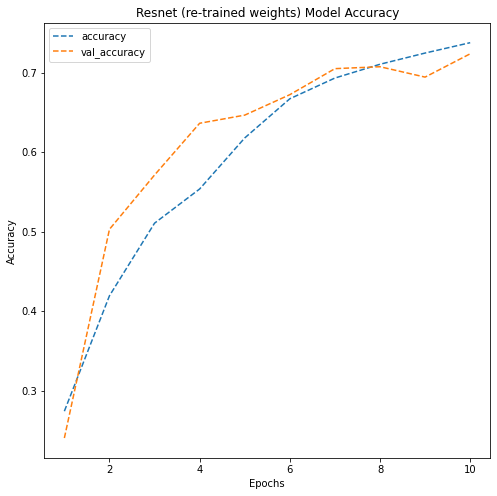

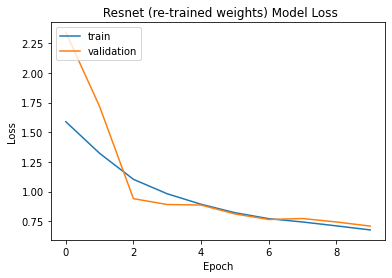

In [118]:
dict_hist = historyRes.history

list_ep = [i for i in range(1, 11)]

plt.figure(figsize = (8, 8))


plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.title('Resnet (re-trained weights) Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

#plot loss of model1
plt.plot(historyRes.history['loss'])
plt.plot(historyRes.history['val_loss'])
plt.title(' Resnet (re-trained weights) Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4/4 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        32
           1       0.79      0.69      0.73        32
           2       0.65      0.81      0.72        32
           3       0.91      0.91      0.91        32

    accuracy                           0.80       128
   macro avg       0.82      0.80      0.81       128
weighted avg       0.82      0.80      0.81       128



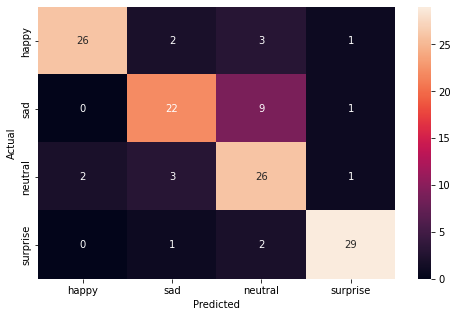

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_images, test_labels = next(test_set)

pred = resnetmodel2.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

print(classification_report(y_true, pred))

cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## **EfficientNet Model**

**Observations
- When retraining the weights on the resnet model, you get significantly better results. 
- The Accuracy gets up to 80% on the training data, and just over 70% on the validation data. 
- There is a little over fitting in this model.
- this is shown as the Training data accuracy supercedes the validation accuracy, and the validation loss goes up past the training loss. 
- this model learns significantly better than the model that used the pretrained resnet weights. 
- the loss gets down to about 0.7 on the validation data and to 0.6 on the training data
- The f1 score increases greatly in every category along with precision and recall.
- suprised has the best precision and recall fallowed by happy then sad then neutral.
- happy is categorized correctly 81% of the time
- Sad is still misclassified as neutral 33% of the time which is not better than the origional cnn models
- neutral is classified correctly 81% of the time as well, which is significantly better than the previous CNN models
- Surprised is correctly classified 90% of the time correctly which is also better than previous CNN models.
- 




**

In [ ]:
from tensorflow.keras import backend

backend.clear_session()




In [15]:
np.random.seed(18)

import random

random.seed(18)

tf.random.set_seed(18)

In [77]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False, weights="imagenet", input_shape= (48, 48, 3))

35839040/35839040 [==============================] - 0s 0us/step


### **Model Building**

In [78]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False

x = Flatten()(transfer_layer_EfficientNet.output)

x = Dense(1024)(x)
x = Activation(LeakyReLU(0.1))(x)
x = Dense(512)(x)
x = Activation(LeakyReLU(0.1))(x)
x = Dense(256)(x)
x = Activation(LeakyReLU(0.1))(x)
x = Dense(128)(x)
x = Activation(LeakyReLU(0.1))(x)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Activation(LeakyReLU(0.1))(x)


pred = Dense(4, activation='softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [79]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )  
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)  

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 20

In [80]:
optimizer = tf.keras.optimizers.Adam(0.0001)

Efficientnetmodel.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [81]:
history3 = Efficientnetmodel.fit(train_set, validation_data = validation_set, epochs = 20)# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.

Epoch 1/20
473/473 [==============================] - 32s 56ms/step - loss: 1.3891 - accuracy: 0.2604 - val_loss: 1.3827 - val_accuracy: 0.2289
Epoch 2/20
473/473 [==============================] - 25s 52ms/step - loss: 1.3845 - accuracy: 0.2631 - val_loss: 1.3730 - val_accuracy: 0.2443
Epoch 3/20
473/473 [==============================] - 25s 52ms/step - loss: 1.3836 - accuracy: 0.2638 - val_loss: 1.3712 - val_accuracy: 0.2289
Epoch 4/20
473/473 [==============================] - 25s 52ms/step - loss: 1.3836 - accuracy: 0.2677 - val_loss: 1.3813 - val_accuracy: 0.2289
Epoch 5/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3832 - accuracy: 0.2638 - val_loss: 1.3713 - val_accuracy: 0.2443
Epoch 6/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3829 - accuracy: 0.2700 - val_loss: 1.3734 - val_accuracy: 0.2289
Epoch 7/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3825 - accuracy: 0.2602 - val_loss: 1.3691 - val_accuracy:

### **Evaluating the EfficientnetNet Model**

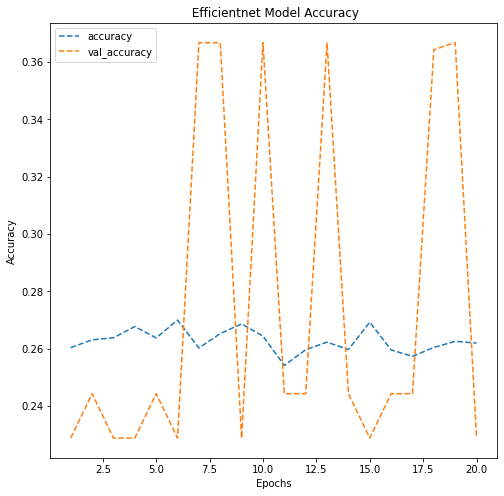

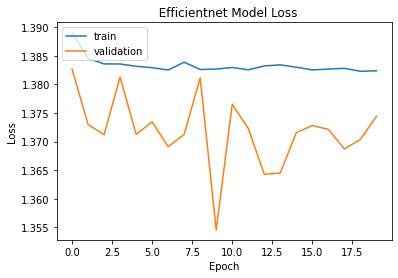

In [83]:
dict_hist = history3.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))


plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.title(' Efficientnet Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

#plot loss of model1
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('  Efficientnet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 

test_images, test_labels = next(test_set)

pred = Efficientnetmodel.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

print(classification_report(y_true, pred))

cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('  Efficientnet Confusion Matrix')
plt.show()

**Observations and Insights:
- The performance of the Efficientnet model is once again horrible
- The validation accuracy reaches 0.367 at 7, 10, 12, and 17, epochs then immediatly drops significantly.
- the training accuracy remains constant around 0.27
- The loss, for training data is 1.384 consistently and the loss for validation accuracy is 1.372
- this shows that this model is pretty much not learning at all.
- I believe this is because the efficientnet model was made for object identification so the weights do not transfer well.
- Looking at the confusion matrix gives no further information as they are all once again classified as happy.
- After adding and removing layers, messing with the learning rate, changing activation types, and learning rate, I could not get the accuracy above 0.367
- Overall the transfer learning achitectures were bad. The only one that came close to doing what it needed to was the vgg16, even still it did not do nearly as well as the CNNs in milestone 1. I am not satisfied with these accuracies. 
- I do not think the issue lies within the colormode
- The issue is that the transfer weights were trained on very different data.


**



Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [32]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

validation_set = datagen_train.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

test_set = datagen_train.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

In [33]:
from tensorflow.keras import backend

backend.clear_session()

In [34]:
# Fixing the seed for random number generators

np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [53]:
no_of_classes = 4

model3 = Sequential()

# Add 1st CNN Block
model3.add(Conv2D(64, kernel_size = 2, padding="same", activation="relu", input_shape=(48,48,1)))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
# Add 2nd CNN Block
model3.add(Conv2D(128, kernel_size = 2, padding="same", activation="relu"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

# Add 3rd CNN Block
model3.add(Conv2D(512, kernel_size = 2, padding="same", activation="relu"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

# Add 4th CNN Block
model3.add(Conv2D(512, kernel_size = 2, padding="same", activation="relu"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

# Add 5th CNN Block
model3.add(Conv2D(256, kernel_size = 2, padding="same", activation="relu"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Flatten())

# First fully connected layer
model3.add(Dense(156, activation= "relu"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(Dropout(0.2))

# Second fully connected layer
model3.add(Dense(512, activation= "relu"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))


model3.add(Dense(4, activation = 'softmax'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [54]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

epochs = 35

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [55]:
optimizer = tf.keras.optimizers.Adam(0.003)
model3.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [56]:
history4 = model3.fit(train_set, validation_data = validation_set, epochs = 35)


Epoch 1/35
473/473 [==============================] - 18s 36ms/step - loss: 1.5379 - accuracy: 0.2698 - val_loss: 1.4372 - val_accuracy: 0.2958
Epoch 2/35
473/473 [==============================] - 17s 35ms/step - loss: 1.4366 - accuracy: 0.2763 - val_loss: 1.5052 - val_accuracy: 0.2978
Epoch 3/35
473/473 [==============================] - 16s 35ms/step - loss: 1.4152 - accuracy: 0.2737 - val_loss: 1.3767 - val_accuracy: 0.3157
Epoch 4/35
473/473 [==============================] - 17s 35ms/step - loss: 1.3926 - accuracy: 0.2923 - val_loss: 1.3585 - val_accuracy: 0.3002
Epoch 5/35
473/473 [==============================] - 17s 35ms/step - loss: 1.3359 - accuracy: 0.3223 - val_loss: 1.3147 - val_accuracy: 0.2889
Epoch 6/35
473/473 [==============================] - 17s 35ms/step - loss: 1.2483 - accuracy: 0.3951 - val_loss: 1.4320 - val_accuracy: 0.3034
Epoch 7/35
473/473 [==============================] - 17s 35ms/step - loss: 1.1872 - accuracy: 0.4527 - val_loss: 2.2591 - val_accuracy:

### **Evaluating the Model on Test Set**

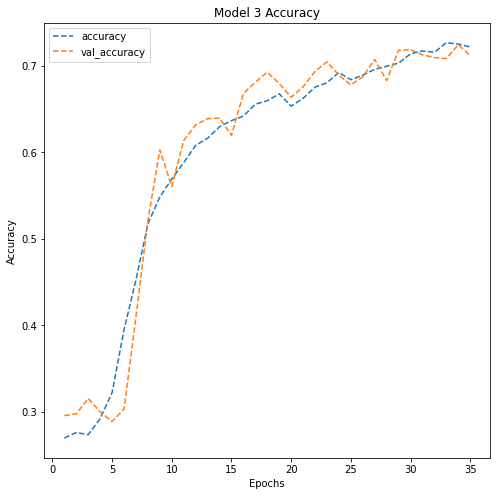

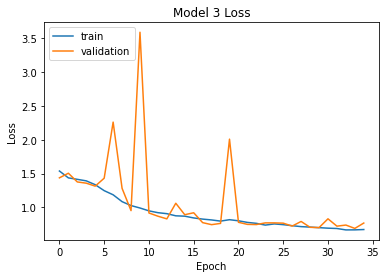

In [117]:

dict_hist = history4.history

list_ep = [i for i in range(1, 36)]

plt.figure(figsize = (8, 8))


plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.title('Model 3 Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()


#plot loss of model1
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Observations and Insights:
- The training accuracy gets up to 0.73.
- The validation accuracy remains around 0.70
- there is not much over fitting in this model.
- both accuracy datasets show that the model levels off at around 
- the validation loss shows a lot of noise, removing the last dropout layer fixed some of that.
- overall, the model learns at a fairly steady rate, and gets lowest at 30 epochs and levels off




**

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.59      0.72      0.65        32
           2       0.64      0.66      0.65        32
           3       0.93      0.88      0.90        32

    accuracy                           0.74       128
   macro avg       0.76      0.74      0.75       128
weighted avg       0.76      0.74      0.75       128



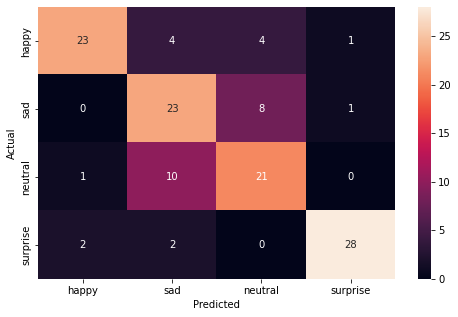

In [45]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)

pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:
- surprise is once again classified the most accuractly, at about 90%
- happy and sad are correctly classified the scond most but happy is misclassified as sad and neutral 12.5% of the time
- Sad is misclassified 25% of the time as neutral.
- the f1 score for sad and nuetral is not very good but the recall on sad is much better than the recall on neutral
- this model still struggles on the difference between neutral and sad misclassifying both as eachother.
- Neutral is misclassified nearly 1/3 of the time as sad.
- None of these are necessarily new insights into the data but This model outperformed the vast majority of other models.






**

## **Conclusion:
- The transfer learning models did not perform as well as i hoped. I would not select any of them as the solution model.
- I would select the Resnet model with the retrained weights. 
- It slightly beats out model 3, in accuracy, F1 scores, and performed better on the test set.
- There is slight over fitting but its performance on the test data nullifies that. 
- The resnet2 model performed better on the neutral faces, and about the same on the sad faces.
- I dont believe there was much of way to improve the performance of the transfer learning sets as far as messing with the models
- One solution that could work would be finding a facial recognition model like vgg face and use those weights that are allready trained.
- I beleive the reason these transfer models performed so poorly was because they are not trained on facial features but random objects, and even though there may be people in the random objects, it was not trained to recognize the features on their faces so transfering the weights is almost meaningless.





**